In [19]:
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.text import Tokenizer 
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from collections import defaultdict
from pathlib import Path
import warnings
from attention import AttentionLayer
from sklearn.model_selection import train_test_split



In [3]:
df = pd.read_csv(r'C:\Users\USER\Documents\GitHub\TextSummarizer\train4.csv')

contraction_map = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}


In [4]:
display(df)

,Text,Summary
0,Claxton hunting first major medal\n\nBritish h...,"For the first time, Claxton has only been prep..."
1,O'Sullivan could run in Worlds\n\nSonia O'Sull...,"The participation of O'Sullivan, currentily tr..."
2,Greene sets sights on world title\n\nMaurice G...,I think when I was coming up I would say there...
3,IAAF launches fight against drugs\n\nThe IAAF ...,"""I am very happy to see you all, members of th..."
4,"Dibaba breaks 5,000m world record\n\nEthiopia'...",Ethiopia's Tirunesh Dibaba set a new world rec...
5,Isinbayeva claims new world best\n\nPole vault...,"In the men's 60m, former Olympic 100m champion..."
6,O'Sullivan commits to Dublin race\n\nSonia O'S...,Carroll will be facing stiff competition from ...
7,Hansen 'delays return until 2006'\n\nBritish t...,Moore said Hansen may be able to return to spr...
8,Off-colour Gardener storms to win\n\nBritain's...,"At the same meeting, finished third in 7.27 s..."
9,Collins to compete in Birmingham\n\nWorld and ...,Collins ran in Birmingham at the 2003 World In...


In [5]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_map[t] if t in contraction_map else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in df['Text']:
    cleaned_text.append(text_cleaner(t))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_map[t] if t in contraction_map else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in df['Summary']:
    cleaned_summary.append(summary_cleaner(t))

df['cleaned_text']=cleaned_text
df['cleaned_summary']=cleaned_summary
df['cleaned_summary'].replace('', np.nan, inplace=True)
df.dropna(axis=0,inplace=True)

# add sostok and eostok at the start and end of summary
df['cleaned_summary'] = df['cleaned_summary'].apply(lambda x: 'sostok' + ' ' + x + ' ' + 'eostok')

max_len_text=80 
max_len_summary=10

In [8]:
display(df)

,Text,Summary,cleaned_text,cleaned_summary
0,Claxton hunting first major medal\n\nBritish h...,"For the first time, Claxton has only been prep...",claxton hunting first major medal british hurd...,sostok for the first time claxton has only bee...
1,O'Sullivan could run in Worlds\n\nSonia O'Sull...,"The participation of O'Sullivan, currentily tr...",sullivan could run worlds sonia sullivan indic...,sostok the participation of sullivan currentil...
2,Greene sets sights on world title\n\nMaurice G...,I think when I was coming up I would say there...,greene sets sights world title maurice greene ...,sostok think when was coming up would say ther...
3,IAAF launches fight against drugs\n\nThe IAAF ...,"""I am very happy to see you all, members of th...",iaaf launches fight drugs iaaf athletics world...,sostok am very happy to see you all members of...
4,"Dibaba breaks 5,000m world record\n\nEthiopia'...",Ethiopia's Tirunesh Dibaba set a new world rec...,dibaba breaks world record ethiopia tirunesh d...,sostok ethiopia tirunesh dibaba set new world ...
5,Isinbayeva claims new world best\n\nPole vault...,"In the men's 60m, former Olympic 100m champion...",isinbayeva claims new world best pole vaulter ...,sostok in the men former olympic champion maur...
6,O'Sullivan commits to Dublin race\n\nSonia O'S...,Carroll will be facing stiff competition from ...,sullivan commits dublin race sonia sullivan se...,sostok carroll will be facing stiff competitio...
7,Hansen 'delays return until 2006'\n\nBritish t...,Moore said Hansen may be able to return to spr...,hansen delays return british triple jumper ash...,sostok moore said hansen may be able to return...
8,Off-colour Gardener storms to win\n\nBritain's...,"At the same meeting, finished third in 7.27 s...",colour gardener storms win britain jason garde...,sostok at the same meeting finished third in s...
9,Collins to compete in Birmingham\n\nWorld and ...,Collins ran in Birmingham at the 2003 World In...,collins compete birmingham world commonwealth ...,sostok collins ran in birmingham at the world ...


In [9]:
from shutil import copyfile
copyfile(src = "./attention/attention.py", dst = "./attention.py")

'./attention.py'

In [10]:
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")


In [11]:
x_tr,x_val,y_tr,y_val=train_test_split(df['cleaned_text'],df['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True) 

In [12]:
#prepare a tokenizer for reviews on training data

x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [13]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [14]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#Preparing LSTM layer 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#Preparing LSTM layer 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#Preparing LSTM layer 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Decoder layer 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 


decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Dense layer
# decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
#decoder_outputs = decoder_dense(decoder_concat_input) 

In [15]:
#Preparing the Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])\

#Adding the dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Prepare the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

# Compiling the RNN model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 500)      279500      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 500), (N 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [16]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [17]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2), 
      

In [20]:
mc = ModelCheckpoint('./Model',monitor='val_loss', verbose=1, 
                      save_best_only=True, mode='min', save_weights_only = False)

In [21]:
# Note: this will take a while. Run as many epochs as needed.
history = model.fit([x_tr, y_tr[:,:-1]], 
                    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:], 
                    epochs=15, 
                    callbacks=[es,mc], 
                    batch_size=128, 
                    validation_data=([x_val, y_val[:, :-1]], 
                                     y_val.reshape(y_val.shape[0], 
                                                   y_val.shape[1], 1)[:,1:])
                    )

Epoch 1/15
1/1 [==============================] - 20s 20s/step - loss: 5.9277 - val_loss: 5.8813

Epoch 00001: val_loss improved from inf to 5.88127, saving model to .\Model


INFO:tensorflow:Assets written to: .\Model\assets


INFO:tensorflow:Assets written to: .\Model\assets


Epoch 2/15
1/1 [==============================] - 14s 14s/step - loss: 5.8035 - val_loss: 5.7862

Epoch 00002: val_loss improved from 5.88127 to 5.78619, saving model to .\Model


INFO:tensorflow:Assets written to: .\Model\assets


INFO:tensorflow:Assets written to: .\Model\assets


Epoch 3/15
1/1 [==============================] - 9s 9s/step - loss: 4.3741 - val_loss: 6.3084

Epoch 00003: val_loss did not improve from 5.78619
Epoch 4/15
1/1 [==============================] - 9s 9s/step - loss: 5.6443 - val_loss: 6.7249

Epoch 00004: val_loss did not improve from 5.78619
Epoch 00004: early stopping


In [24]:
# serialize model to JSON
model_json = model.to_json()
with open("summary.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("summary.h5")
print("Saved model to disk")

Saved model to disk


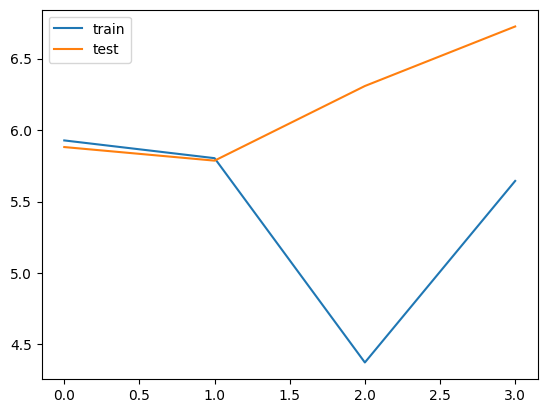

In [27]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [28]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [29]:
# # Inference Models

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [30]:
def decode_sequence(input_sequence):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_sequence)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'eostok' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence
    
## Making the seq2seq summary
def seq2seqsummary(input_sequence):
    newString=''
    for i in input_sequence:
      if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_sequence):
    newString=''
    for i in input_sequence:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString


In [31]:
import csv

hyps = []
with open('./result.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['Article', 'Original Summary', 'Summarized'])
    for i in range(9):
        text = seq2text(x_tr[i])
        ori_summ = seq2seqsummary(y_tr[i])
        our_summ = decode_sequence(x_tr[i].reshape(1, max_len_text))
        hyps.append(our_summ)
        writer.writerow([text, ori_summ, our_summ])

In [ ]:
for i in range(0,9):
  print("Article:",seq2text(x_tr[i]))
  print("Original summary:",seq2seqsummary(y_tr[i]))
  print("Summarized:",decode_sequence(x_tr[i].reshape(1,max_len_text)))
  print("\n")
